### Rappel Google Colab

Tout d'abord, sélectionnez l'option GPU de Colab avec *Edit > Notebook settings* et sélectionner GPU comme Hardware accelerator. 
Installer ensuite deeplib avec la commande suivante:

In [ ]:
!pip install git+https://github.com/ulaval-damas/glo4030-labs.git

# Laboratoire 5: CNN

Dans ce laboratoire, nous allons implémenter avec l'aide de PyTorch divers réseaux à convolutions. La [documentation de PyTorch](https://pytorch.org/docs/stable/index.html) va donc vous être d'un grand secours. Entre autres, la documentation de [`torch`](https://pytorch.org/docs/stable/torch.html), [`torch.nn`](https://pytorch.org/docs/stable/nn.html) (que nous avons importé sous le nom de `nn`) ainsi que [`torch.nn.functional`](https://pytorch.org/docs/stable/nn.functional.html) (que nous avons importé sous le nom de `F`). En particulier, voici une liste de classes ou de fonctions dont vous êtes susceptible d'utiliser au cours de ce laboratoire.
- [`nn.Conv2d`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d)
- [`nn.BatchNorm2d`](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html#torch.nn.BatchNorm2d)
- [`F.max_pool2d`](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.max_pool2d) ou [`nn.MaxPool2d`](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html#torch.nn.MaxPool2d)
- [`F.relu`](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.relu) ou [`nn.ReLU`](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU)
- [`torch.flatten`](https://pytorch.org/docs/stable/generated/torch.flatten.html#torch.flatten) ou [`nn.Flatten`](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html#torch.nn.Flatten)
- [`nn.Linear`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear)
- [`nn.Sequential`](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html#torch.nn.Sequential)
- [`nn.ModuleList`](https://pytorch.org/docs/stable/generated/torch.nn.ModuleList.html#torch.nn.ModuleList)

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from deeplib.training import train, test
import torch.optim as optim
import torch
import numpy as np
from deeplib.datasets import load_cifar10, load_mnist
from deeplib.visualization import view_filters
import torch.nn.functional as F
import torch.nn as nn
from random import randrange

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 150

cifar_train, cifar_test = load_cifar10()
mnist_train, mnist_test = load_mnist()

## Filtres de convolution

Lors de l'entraînement, le réseau apprend les bons paramètres à utiliser. Par contre, autrefois, il fallait utiliser des filtres faits à la main comme [les filtres de Gabor](https://en.wikipedia.org/wiki/Gabor_filter).

#### Exercice

- Le réseau suivant contient une seule couche à convolution. Créez manuellement quelques filtres que vous utiliserez pour faire de la classification sur MNIST. Par la suite, figez les poids de la couche de convolution et entraînez le réseau. Tentez d'obtenir les meilleurs résultats possibles.

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 3, padding=1)
        self.fc = nn.Linear(6 * 14 * 14, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = x.flatten(1)
        x = self.fc(x)
        return x

Modifier les paramètres des filtres. Essayez de faire des filtres permettant d'extraire des caractéristiques de bas niveau (ligne, coin, etc...). Vous pouvez consulter [ceci](http://lodev.org/cgtutor/filtering.html) pour avoir des idées.

In [ ]:
filters = []
filters.append([[[0, 0, 0],
                 [0, 1, 0],
                 [0, 0, 0]]]) # Ce filtre retourne l'image original

filters.append([[[0, 0, 0],
                 [0, 0, 0],
                 [0, 0, 0]]])

filters.append([[[0, 0, 0],
                 [0, 0, 0],
                 [0, 0, 0]]])

filters.append([[[0, 0, 0],
                 [0, 0, 0],
                 [0, 0, 0]]])

filters.append([[[0, 0, 0],
                 [0, 0, 0],
                 [0, 0, 0]]])

filters.append([[[0, 0, 0],
                 [0, 0, 0],
                 [0, 0, 0]]])

In [ ]:
# On crée le réseau, remplace les paramètres par les filtres précédents et fige les poids.

net = Net()
filters = np.asarray(filters, dtype=np.float32)
net.conv1.weight.data = torch.from_numpy(filters)
for param in net.conv1.parameters():
    param.requires_grad = False # Ceci fige chacune des couches
net = net.cuda()

In [ ]:
# Vous pouvez utiliser cette cellule pour visualiser l'effet de vos filtres sur des images du dataset.
for i in range(3):
    image, label = mnist_train[randrange(0, len(mnist_train))]
    view_filters(net, image)

In [ ]:
lr = 0.001
n_epoch = 5
batch_size = 32

In [ ]:
optimizer = optim.Adam(net.fc.parameters(), lr=lr) # On optimise uniquement la couche pleinement connectée.
history = train(net, optimizer, mnist_train, n_epoch, batch_size)
history.display()
print('Précision en test: {:.2f}'.format(test(net, mnist_test, batch_size)))

Entraînons maintenant le même réseau mais cette fois-ci, laissez l'optimiseur Adam faire son travail d'optimiser les couches à convolutions. Nous pourrons en même temps comparer si nos filtres faits à la main compétitionne avec les filtres entraînés. Remarquez cependant qu'ici, nous entraînons seulement avec 6 filtres et 1 seule couche alors qu'il est possible d'entraîner un réseau avec des milliers de filtres et plusieurs dizaines de couches.

In [ ]:
net = Net()
net.cuda()

# On optimise autant la couche à convolution que la couche de classification.
optimizer = optim.Adam(net.parameters(), lr=lr)

history = train(net, optimizer, mnist_train, n_epoch, batch_size)
history.display()
print('Précision en test: {:.2f}'.format(test(net, mnist_test, batch_size)))

Visualisons les filtres qui ont été appris par le réseau.

In [ ]:
for i in range(3):
    image, label = mnist_train[randrange(0, len(mnist_train))]
    view_filters(net, image)

## Utilisation des filtres à convolutions

Comme on peut le constater dans l'interface de la classe [`nn.Conv2d`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d) de PyTorch, les couches à convolutions ont des hyperparamètres ayant tous divers effets. Dans cette section, nous explorerons les plus importants.

Voici donc l'interface simplifiée de la classe:

`nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0)`

Lorsqu'on utilise la classe, elle s'attend à recevoir en entrée un tenseur de taille `(taille de la batch, canaux, hauteur, largeur)`. Par exemple dans le cas de CIFAR10, on aurait en tenseur de taille `(taille de la batch, 3, 32, 32)`. Créons-nous un tenseur de taille similaire avec une taille de batch de 8 afin de tester la classe `nn.Conv2d` de PyTorch.

In [ ]:
image_batch = torch.randn(8, 3, 32, 32)

Notez que le premier paramètre `in_channels` de `nn.Conv2d` doit correspondre au nombre de canaux (*channels*) du tenseur donné en entrée de la couche. Par exemple, la couche à convolution de 100 filtres 3x3 que l'on crée dans **le code suivant va nous donner une erreur** étant donné qu'on spécifie 2 canaux au lieu de 3.

In [ ]:
conv = nn.Conv2d(2, 100, 3)
conv(image_batch)

Créons maintenant une couche à convolution de 100 filtres 3x3 avec le bon nombre de canaux en entrée et regardons la shape du tenseur résultant.

In [ ]:
conv = nn.Conv2d(3, 100, 3)
conv(image_batch).shape

On remarque que la taille du tenseur de sortie a 100 canaux étant donné qu'on a demandé 100 filtres à convolution. On remarque aussi que la hauteur et la largeur ont diminué de 2 dû à la convolution. Pour pallier à ceci, ajoutons un padding de 1.

In [ ]:
conv = nn.Conv2d(3, 100, 3, padding=1)
conv(image_batch).shape

#### Exercice

- Quand vient le temps d'empiler les couches à convolution, il faut tenir compte du nombre de canaux en sortie de la couche précédente pour la couche suivante. Corrigez le code ci-dessous pour que l'appel des couches à convolution s'effectue sans erreur.

In [ ]:
# TODO Corrigez le code suivant
conv1 = nn.Conv2d(3, 32, 3, padding=1)
conv2 = nn.Conv2d(64, 100, 3, padding=1)
conv2(conv1(image_batch)).shape

#### Exercice

- Testons maintenant avec des filtres de tailles différentes. On remarquera que la hauteur et la largeur ont changé avec des filtres plus gros. Ajustez le padding pour que la hauteur et la largeur restent les mêmes, c'est-à-dire 32x32.

In [ ]:
conv = nn.Conv2d(3, 100, 5, padding=2)
print("Filtre 5x5:", conv(image_batch).shape)

conv = nn.Conv2d(3, 100, 7, padding=3)
print("Filtre 7x7:", conv(image_batch).shape)

Mettons maintenant un *stride* de 2. Ceci va faire en sorte que les filtres à convolutions auront des déplacements de taille 2 au lieu de 1.

In [ ]:
conv = nn.Conv2d(3, 100, 3, padding=1, stride=2)
conv(image_batch).shape

On remarque que la hauteur et la largeur du tenseur résultant ont été divisées par 2.

## Architecture de base

#### Exercice

- Implémentez une architecture de base de réseau de neurones à convolution pour CIFAR10 ayant les caractéristiques suivantes.

    1. 3 couches à convolution (voir [`nn.Conv2d`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d)).
    2. Toutes les couches ont 100 filtres de taille 3x3 et 1 de padding.
    3. Batch normalization après chaque couche (voir [`nn.BatchNorm2d`](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html#torch.nn.BatchNorm2d)).
    4. Utiliser la ReLU comme fonction d'activation (Voir [`F.relu`](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.relu) ou [`nn.ReLU`](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU)).
    5. Maxpooling avec un noyau de taille 2 après les 2 premières couches. (Voir [`F.max_pool2d`](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.max_pool2d) ou [`nn.MaxPool2d`](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html#torch.nn.MaxPool2d)).
    6. 1 seule couche linéaire pour la classification (aucune activation nécessaire) (Voir [`nn.Linear`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear)).

Ne pas oublier d'utiliser [`torch.flatten`](https://pytorch.org/docs/stable/generated/torch.flatten.html#torch.flatten) ou [`nn.Flatten`](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html#torch.nn.Flatten) avant la couche de classification sinon vous allez obtenir des erreurs de *shape*.

Essentiellement, chaque couche devrait consister en `Conv2d -> BatchNorm2d -> ReLU` suivi de `MaxPool2d` pour les deux premières couches. Notez que le maxpooling et la ReLU pourraient être échangés étant donné que tous les deux sont des opérations de maximum. Pour vous faciliter les prochains exercices, on vous demande de suivre l'ordre donné ici.

Notez que la taille des images de CIFAR10 est de 3x32x32 (images en couleur). Il faut donc tenir en compte de cela lors de l'instanciation de la première couche à convolutions.

In [ ]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        pass

    def forward(self, x):
        pass

In [ ]:
lr = 0.001
n_epoch = 5
batch_size = 32

In [ ]:
model = ConvNet()
model.cuda()

optimizer = optim.Adam(model.parameters(), lr=lr)
history = train(model, optimizer, cifar_train, n_epoch, batch_size)
history.display()
print('Précision en test: {:.2f}'.format(test(model, cifar_test, batch_size)))

## Architecture profonde

#### Exercice

- Ajoutez 2 couches de convolution de 100 filtres dans le réseau précédent (n'oubliez pas la batch normalization et le padding). Mettez du maxpooling après la couche 1 et 3. Comparez les résultats.

In [ ]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        pass

    def forward(self, x):
        pass

In [ ]:
model = ConvNet()
model.cuda()

optimizer = optim.Adam(model.parameters(), lr=lr)
history = train(model, optimizer, cifar_train, n_epoch, batch_size)
history.display()
print('Précision en test: {:.2f}'.format(test(model, cifar_test, batch_size)))

#### Question
- Que remarquez-vous par rapport au performance du réseau précédent?

#### Exercice

- Codez le réseau ci-dessous qui prend en paramètre le nombre de couches désiré. Vous allez devoir utiliser la classe [`nn.ModuleList`](https://pytorch.org/docs/stable/generated/torch.nn.ModuleList.html#torch.nn.ModuleList) pour pouvoir avoir un nombre variable de couches. Encore une fois, chaque couche va consister en 100 filtres à convolution 3x3 avec padding de 1 suivi d'une batch normalization et d'une ReLU. Mettez du maxpooling après les couches 3 et 5. Vous pouvez supposer que le nombres de couche demandé est plus de 5. Entrainez ensuite le réseau avec 51 couches.

    L'entraînement risque de prendre un certain temps. Vous avez certainement le temps d'aller prendre un bon café.

In [ ]:
class ConvNet(nn.Module):
    def __init__(self, num_layers):
        super().__init__()
        assert num_layers > 5
        pass

    def forward(self, x):
        pass

In [ ]:
model = ConvNet(51)
model.cuda()

optimizer = optim.Adam(model.parameters(), lr=lr)
history = train(model, optimizer, cifar_train, n_epoch, batch_size)
history.display()
print('Précision en test: {:.2f}'.format(test(model, cifar_test, batch_size)))

#### Question

- Que remarquez-vous par rapport au performance du réseau précédent?

### Un petit défi (exercice facultatif)

PyTorch fournit l'interface de programmation [`nn.Sequential`](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html#torch.nn.Sequential) permettant de programmer et de visualiser plus facilement les réseaux programmables sous forme de couches. Au lieu d'hériter de la classe [`nn.Module`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module), on instancie un objet `nn.Sequential` avec les couches désirés en paramètre. L'objet `nn.Sequential` se chargera d'appeler dans l'ordre fourni chaque couche avec en entrée la sortie de la couche précédente.

Prenons l'exemple ci-dessous qui contient seulement une couche à convolutions, quelques activations et une couche linéaire.

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 100, 3, padding=1)
        self.fc = nn.Linear(100 * 16 * 16, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = x.flatten(1)
        x = self.fc(x)
        return x

net = Net()
print(net)

En utilisant l'interface `nn.Sequential`, On peut simplifier le code comme ci-dessous. On remarquera également qu'avec l'affichage d'un réseau utilisant `nn.Sequential`, les opérations exécutées par le réseau sont beaucoup clairs et explicites qu'avec `nn.Module`.

In [ ]:
def create_sequential_network():
    return nn.Sequential(
        nn.Conv2d(3, 100, 3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Flatten(),
        nn.Linear(100 * 16 * 16, 10)
    )

net = create_sequential_network()
print(net)

On vous soumet donc ici un défi. Le but est de réimplémenter le réseau que l'on vient de coder en utilisant l'interface `nn.Sequential`.

In [ ]:
def create_sequential_conv_net(num_layers):
    assert num_layers > 5
    layers = []

    # TODO Ajoutez les couches à la liste "layers" ici.

    return nn.Sequential(*layers)

Il n'est pas nécessaire d'effectuer l'entraînement au complet, juste de confirmer que votre implémentation a des performances similaires à votre implémentation précédente.

In [ ]:
model = create_sequential_conv_net(51)
model.cuda()

optimizer = optim.Adam(model.parameters(), lr=lr)
history = train(model, optimizer, cifar_train, n_epoch, batch_size)
history.display()
print('Précision en test: {:.2f}'.format(test(model, cifar_test, batch_size)))

## Connexion résiduelle

Comme vous avez pu le constater, ajouter de plus en plus de couches augmente aussi la difficulté avec laquelle le gradient peut se propager dans le réseau. Une des solutions suggérées est d'utiliser une connexion résiduelle permettant au gradient de _sauter_ des couches. Dans l'article présentant cette connexion, elle est définie comme suit:

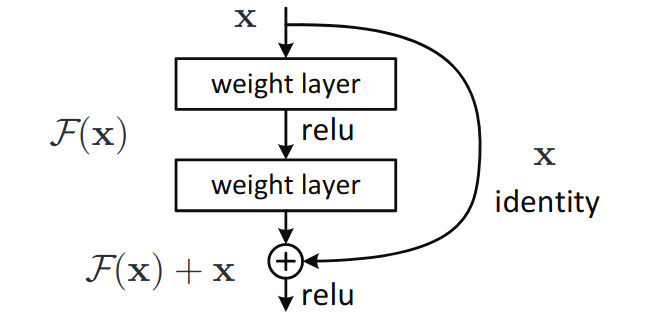

#### Exercice

- Implémentez cette connexion sous une forme de couche dans la classe `ResidualLayer` ci-dessous. Vous pouvez la tester avec le réseau `ShallowResnet` fourni ci-bas. Dans notre cas, chaque *weight layer* consiste en une couche à convolution à 100 filtres 3x3 avec padding de 1 suivi d'une batch normalization. Prenez pour acquis que le nombre de *canaux* en entrée de votre couche sera de 100.

In [ ]:
class ResidualLayer(nn.Module):
    def __init__(self):
        super().__init__()
        pass
    
    def forward(self, x):
        pass

Testez votre implémentation de votre couche résiduelle avec le réseau peu profond ci-dessous.

In [ ]:
class ShallowResnet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 100, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(100)
        
        self.res1 = ResidualLayer()
        self.res2 = ResidualLayer()
        self.res3 = ResidualLayer()

        self.fc1 = nn.Linear(100 * 8 * 8, 10)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.res1(x)
        x = F.max_pool2d(x, 2)
        x = self.res2(x)
        x = F.max_pool2d(x, 2)
        x = self.res3(x)
        x = x.flatten(1)
        x = self.fc1(x)
        return x

Il n'est pas nécessaire d'effectuer l'entraînement au complet, juste de confirmer que votre implémentation a des "bonnes" performances.

In [ ]:
model = ShallowResnet()
model.cuda()

optimizer = optim.Adam(model.parameters(), lr=lr)
history = train(model, optimizer, cifar_train, n_epoch, batch_size)
history.display()
print('Précision en test: {:.2f}'.format(test(model, cifar_test, batch_size)))

#### Exercice

- Codez le réseau à connexion résiduelle ci-dessous qui prend en paramètre le nombre de couches résiduelles désiré. Encore une fois, vous allez devoir utiliser la classe [`nn.ModuleList`](https://pytorch.org/docs/stable/generated/torch.nn.ModuleList.html#torch.nn.ModuleList) ou [`nn.Sequential`](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html#torch.nn.Sequential) pour pouvoir avoir un nombre variable de couches. Notez qu'ici `num_layers` représente le nombre de couches résiduelles et non le nombre de couches à convolution. Le réseau devrait consister d'une couche `Conv2d -> BatchNorm2d -> ReLU` suivi de `num_layers` couches résiduelles et terminer par la couche de classification. Faites un maxpool après les couches résiduelles 1 et 2. 

    Entrainez le réseau avec 25 couches résiduelles (donc au total 51 couches à convolution si compte la première couche non résiduelle).

In [ ]:
class Resnet(nn.Module):
    def __init__(self, num_layers):
        super(Resnet, self).__init__()
        pass

    def forward(self, x):
        pass

In [ ]:
model = Resnet(25)
model.cuda()

optimizer = optim.Adam(model.parameters(), lr=lr)
history = train(model, optimizer, cifar_train, n_epoch, batch_size)
history.display()
print('Précision en test: {:.2f}'.format(test(model, cifar_test, batch_size)))

#### Question

- Comparez les résultats et la vitesse avec laquelle le réseau a entraîné par rapport au réseau à convolution de 51 couches entrainé plus haut.

#### Exercice facultatif

- Comme le défi lancé précédemment, tentez d'implémenter le réseau à connexion résiduelle en n'utilisant que l'interface `nn.Sequential`. Vous pouvez utiliser la couche `ResidualLayer` définie précédemment.

In [ ]:
def create_sequential_resnet(num_layers):
    assert num_layers > 2
    layers = []
    
    # TODO Ajoutez les couches à la liste "layers" ici.

    return nn.Sequential(*layers)

Il n'est pas nécessaire d'effectuer l'entraînement au complet, juste de confirmer que votre implémentation a des performances similaires à votre implémentation précédente.

In [ ]:
model = create_sequential_resnet(25)
model.cuda()

optimizer = optim.Adam(model.parameters(), lr=lr)
history = train(model, optimizer, cifar_train, n_epoch, batch_size)
history.display()
print('Précision en test: {:.2f}'.format(test(model, cifar_test, batch_size)))